In [16]:
from bokeh.plotting import figure, show, ColumnDataSource, reset_output
from bokeh.io import output_notebook, vform
from ipywidgets import widgets, interact, Dropdown, widget_button, Button
from IPython.display import display, clear_output
from random import random

import matplotlib.pyplot as plt
import numpy as np
import warnings
import bokeh

%matplotlib inline

warnings.filterwarnings('ignore')

In [17]:
output_notebook()

Loading BokehJS ...

In [18]:
class PMF(object):
    
    def __init__(self):
        self.distribution = dict()
        
    def set_distribution(self, possibilities):
        """
        Pass in a dictionary, where key = x-value, and value = probability of that value.
        
        Automatically normalizes the distribution such that the likelihood values sum to 1.
        """
        if isinstance(possibilities, dict):
            self.distribution = possibilities
            self.normalize()
        else:
            raise Error('possibilities must be a dictionary of [numerical_value : numerical_value].')
            
    def normalize(self):
        sum_distribution = sum([v for k, v in self.distribution.items()])        
        for k, v in self.distribution.items():
            self.distribution[k] = v / sum_distribution
    def plot(self):
        p = figure(height=300, width=300)
        p.circle(list(self.distribution.keys()), list(self.distribution.values()))
        bokeh.plotting.show(p)

In [19]:
class Binomial(PMF):
    def update(self, success=True):
        for k, v in self.distribution.items():
            if success:
                self.distribution[k] = self.distribution[k] * k / len(self.distribution)
            else:
                self.distribution[k] = self.distribution[k] * (1 - k / len(self.distribution))
        self.normalize()
        


In [20]:
def toss():
    return random() < 0.3

In [21]:
from collections import Counter

possibilities = dict([(i, 1) for i in range(101)])
cointoss = Binomial()
cointoss.set_distribution(possibilities)
tosses = []
p = figure(plot_height=300, plot_width=300)

source = ColumnDataSource(data=dict(x=list(cointoss.distribution.keys()),
                                    y=list(cointoss.distribution.values())),
                         )
p.circle(source.data['x'], source.data['y'])
fig = plt.figure() 
ax = fig.add_subplot(111)
plt.close()

In [22]:
def update(button):
    
    t = toss()
    cointoss.update(t)
    tosses.append(t)
    source.data['y'] = list(cointoss.distribution.values())
    source.push_notebook()
    show(p)
    clear_output(wait=True)
    cointoss.plot()

# plt.scatter(list(cointoss.distribution.keys()),
#             list(cointoss.distribution.values()))
def update_mpl(button):
    t = toss()
    cointoss.update(t)
    tosses.append(t)    
    #line1  = ax.scatter(list(cointoss.distribution.keys()), 
    #                    list(cointoss.distribution.values()))
    clear_output(wait=True)
    plt.scatter(list(cointoss.distribution.keys()),
                list(cointoss.distribution.values()))
    plt.title('{0} coin tosses, {1}'.format(len(tosses), Counter(tosses)))
    
button = Button(description='Toss a coin!', )
button.on_click(update)
display(button)
# show(p)
# interact(tosses, n_tosses=[0, 50, 1])

# Let's use `pymc3` to do modelling

In [23]:
from pymc3 import Model, Uniform, Bernoulli, NUTS, sample, find_MAP, traceplot, Exponential, Metropolis
from collections import Counter

In [24]:
tosses = [toss() for i in range(10000)]

n_steps = 10000  # the number of steps in the MCMC chain

Counter({False: 6928, True: 3072})
Applied interval-transform to p and added transformed p_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 4.1 sec

array([ 0.29794088,  0.31592576])

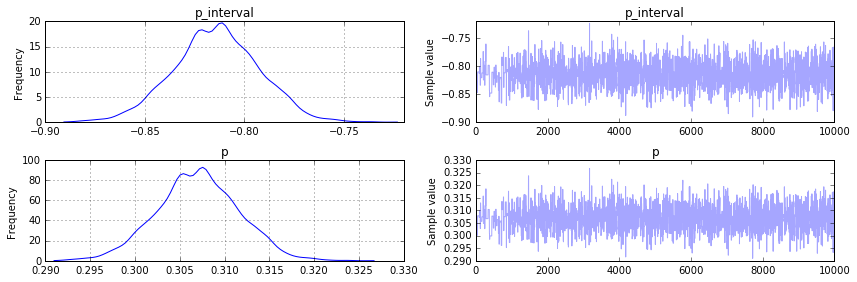

In [25]:
uniform_model = Model()

print(Counter(tosses))
with uniform_model:
    # Priors
    p = Uniform('p', lower=0, upper=1)
    
    # Likelihood
    Y_obs = Bernoulli('y_observed', p, observed=tosses)
with uniform_model:
    step = Metropolis(p)
    trace = sample(n_steps, step=step)
    
%matplotlib inline
traceplot(trace)
np.percentile(trace.get_values('p'), [2.5, 97.5])

Counter({False: 6928, True: 3072})
Applied log-transform to p and added transformed p_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 3.1 sec

array([ 0.29830477,  0.31602067])

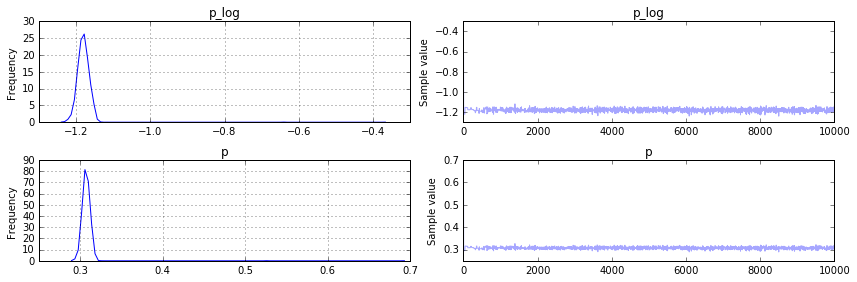

In [26]:
exponential_model = Model()

print(Counter(tosses))

with exponential_model:
    # Priors
    p = Exponential('p', lam=1)
    
    # Likelihood
    Y_obs = Bernoulli('y_observed', p, observed=tosses)

with exponential_model:
    step = Metropolis(p)
    trace = sample(n_steps, step=step)
    
%matplotlib inline
traceplot(trace)
np.percentile(trace.get_values('p'), [2.5, 97.5])

# Further Reading for Interest

- [Think Bayes][1] by Allen Downey.

[1]: http://greenteapress.com/thinkbayes/